錄影：
https://drive.google.com/file/d/1gKHSEju6zfGC69I39wYyDEkCPxFb9KhF/view?usp=share_link


參考資料: 
https://www.readfog.com/a/1670538897518596096

## Control Point

In [ ]:
batch_size = 8
LR = 1e-5
EPOCHS = 3

## 載入資料

In [ ]:
from google.colab import drive
import pandas as pd
# 此處需要登入google帳號
drive.mount('/content/gdrive') 
# 獲取授權碼之後輸入即可連動雲端硬碟
df = pd.read_excel("/content/gdrive/My Drive/bert model/2016_modified_IND.xlsx")

Mounted at /content/gdrive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32936 entries, 0 to 32935
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  32936 non-null  int64 
 1   Tone        32936 non-null  object
 2   Year        32936 non-null  int64 
 3   Company     32936 non-null  int64 
 4   Text        32936 non-null  object
 5   IND         32873 non-null  object
dtypes: int64(3), object(3)
memory usage: 1.5+ MB


In [ ]:
# 語調分佈
plot_df = df.groupby('Tone')[['Text']].count()
plot_df['percentage'] = plot_df['Text']/len(df)
plot_df

,Text,percentage
Tone,,
中,19412,0.589385
正,9984,0.303133
負,3540,0.107481


In [ ]:
# 留下 Tone, Text column 放入BERT 中
df1 = df[['Tone', 'Text', 'IND']]
df1.head(3)

,Tone,Text,IND
0,中,"壹、致股東報告書各位股東本公司105年度合併營業收入為新台幣9,309,660仟元",其他
1,正,"稅前淨利新台幣959,988仟元，較104年度增加51.35%",其他
2,中,"因國際鉛價上揚、存貨金額提高，致營業活動之現金流入較去年減少814,449仟元",其他


## 切分訓練、測試、驗證資料

In [ ]:
import numpy as np
np.random.seed(112)
df_train, df_test = np.split(df1.sample(frac=1, random_state=42), 
                                     [int(.8*len(df))])

print('train data: ', len(df_train))
print('比例：',  len(df_train)/len(df1))
print('test data: ', len(df_test))
print('比例：',  len(df_test)/len(df1))

train data:  26348
比例： 0.7999757104687879
test data:  6588
比例： 0.20002428953121204


Train data:  26348


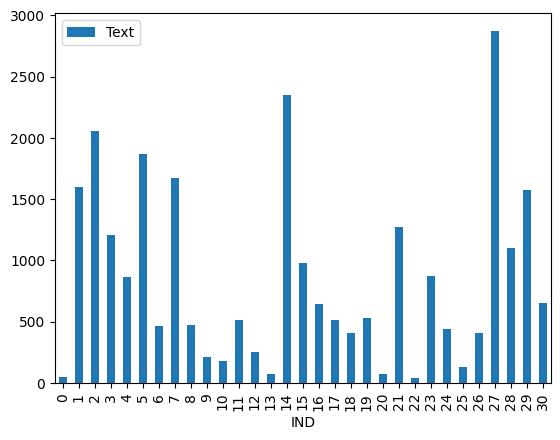

Train data:  6588


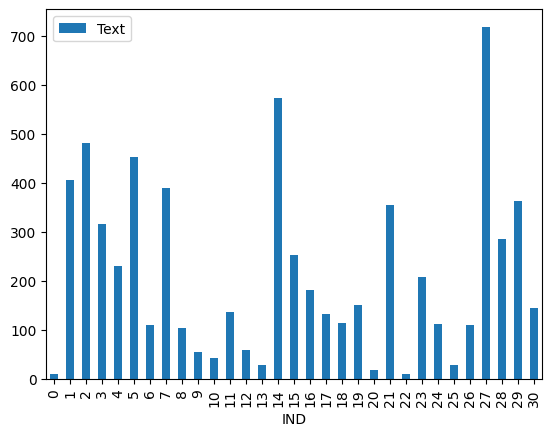

In [ ]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_train['IND'] = df_train['IND'].fillna('N')
df_test['IND'] = df_test['IND'].fillna('N')

pdf = df_train.groupby('IND', as_index = False)[['Text']].count()
pdf['IND'] = encoder.fit_transform(pdf['IND'])
print('Train data: ',pdf['Text'].sum())
pdf.plot(x='IND', y='Text', kind='bar')
plt.show()

pdf2 = df_test.groupby('IND', as_index = False)[['Text']].count()
pdf2['IND'] = encoder.fit_transform(pdf2['IND'])
print('Train data: ',pdf2['Text'].sum())
pdf2.plot(x='IND', y='Text', kind='bar')
plt.show()

In [ ]:
# df_train語調分佈
plot_df = df_train.groupby('Tone')[['Text']].count()
plot_df['percentage'] = plot_df['Text']/len(df_train)
plot_df

,Text,percentage
Tone,,
中,15507,0.588546
正,7990,0.303249
負,2851,0.108206


In [ ]:
# df_test語調分佈
plot_df1 = df_test.groupby('Tone')[['Text']].count()
plot_df1['percentage'] = plot_df1['Text']/len(df_test)
plot_df1

,Text,percentage
Tone,,
中,3905,0.592744
正,1994,0.302672
負,689,0.104584


## 載入BERT

In [ ]:
!pip install transformers
from transformers import BertModel,BertTokenizer
BERT_PATH = 'bert-base-chinese'
tokenizer = BertTokenizer.from_pretrained(BERT_PATH)
bert = BertModel.from_pretrained(BERT_PATH)
print('load bert model over')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.7 MB/s eta 0:00:00


Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


load bert model over


## DEMO BERT Tokenizer

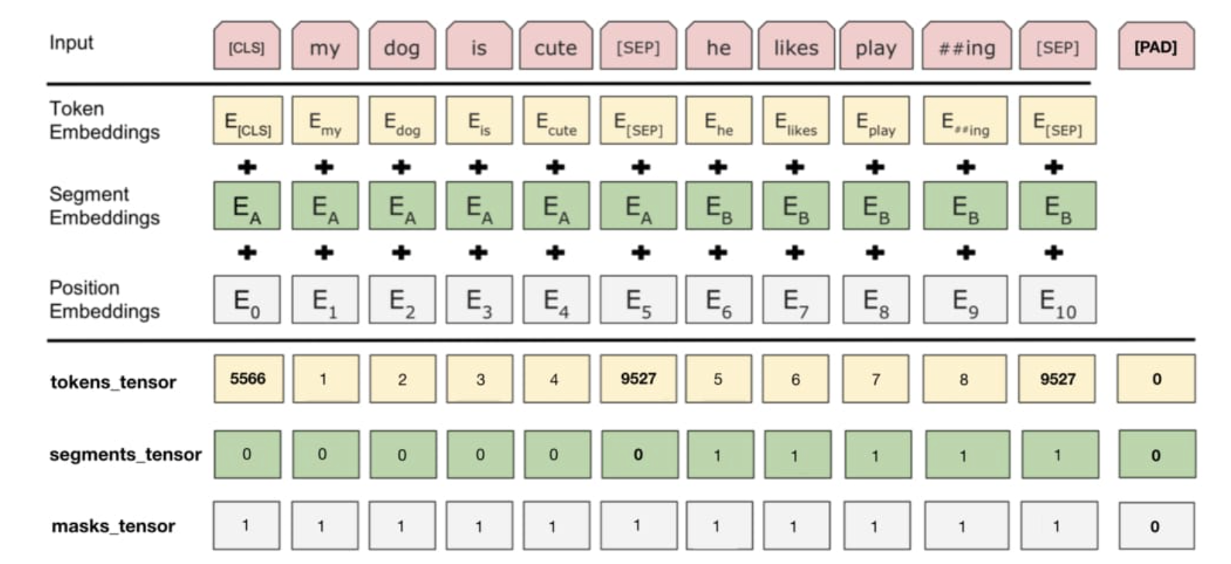

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
example_text = '優化的產品組合帶動了獲利的成長'
bert_input = tokenizer(example_text,padding='max_length', 
                       max_length = 20, 
                       truncation=True,
                       return_tensors="pt")
# ------- bert_input ------
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[ 101, 1032, 1265, 4638, 4496, 1501, 5175, 1394, 2380, 1240,  749, 4363,
         1164, 4638, 2768, 7269,  102,    0,    0,    0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)

[CLS] 優 化 的 產 品 組 合 帶 動 了 獲 利 的 成 長 [SEP] [PAD] [PAD] [PAD]


## 將資料轉換成BERT輸入形式

In [ ]:
import torch
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
labels = { '正':0,
        '負':1,
        '中':2
          }

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['Tone']]
        self.texts = [tokenizer(text, 
                                padding='max_length', 
                                max_length = 300, 
                                truncation = True,
                                return_tensors = "pt") 
                      for text in df['Text']]

    def classes(self):
        # 正、中、負分類
        return self.labels

    def __len__(self):
        # 計算資料集總共數量
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        # 從數據集中獲取位於數據集中特定索引位置的元素
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

## 建立BERT分類模型

In [ ]:
# torch.nn 包含用於構建神經網絡的模組和可擴展類別
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 3)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids = input_id, attention_mask = mask, return_dict = False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        return final_layer

In [ ]:
# torch.optim 其中包含SGD和Adam之類的標準優化操作
from torch.optim import Adam
from tqdm import tqdm
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
import numpy as np

def train(model, train_data, learning_rate, epochs, k = 3, batch_size = batch_size):
    # 通過Dataset類獲取訓練資料
    train_data = Dataset(train_data)

    # 判斷是否使用GPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # 定義損失函數和優化器
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    kf = KFold(n_splits=k, shuffle=True)
    for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
        print(f'Fold: {fold + 1}')
        print(len(train_index))
        print(len(val_index))

        # DataLoader根據batch_size獲取數據，訓練時選擇打亂樣本
        train_sampler = SubsetRandomSampler(train_index)
        val_sampler = SubsetRandomSampler(val_index)

        train_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        val_dataloader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

        # 開始進入訓練循環
        for epoch_num in range(epochs):
            # 定義兩個變量，用於存儲訓練集的準確率和損失
            total_acc_train = 0
            total_loss_train = 0
            model.train()

            # 進度條函數tqdm
            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                # 通過模型得到輸出
                output = model(input_id, mask)
                # 計算損失
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                # 計算精度
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                # 模型更新
                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            # ------ 驗證模型 -----------
            # 定義兩個變量，用於存儲驗證集的準確率和損失
            total_acc_val = 0
            total_loss_val = 0
            model.eval()
            # 不需要計算梯度
            with torch.no_grad():
                # 循環獲取數據集，並用訓練好的模型進行驗證
                for val_input, val_label in val_dataloader:
                   # 如果有GPU，則使用GPU，接下來的操作同訓練
                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'''Epochs: {epoch_num + 1} 
                  | Train Loss: {total_loss_train / len(train_sampler): .3f} 
                  | Train Accuracy: {total_acc_train / len(train_sampler): .3f} 
                  | Val Loss: {total_loss_val / len(val_sampler): .3f} 
                  | Val Accuracy: {total_acc_val / len(val_sampler): .3f}''')


## Run Model

In [ ]:
from transformers import BertForSequenceClassification
EPOCHS = EPOCHS
model = BertClassifier()
LR = LR
train(model, df_train, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 1
17565
8783


100%|██████████| 2196/2196 [15:59<00:00,  2.29it/s]


Epochs: 1 
                  | Train Loss:  0.062 
                  | Train Accuracy:  0.796 
                  | Val Loss:  0.049 
                  | Val Accuracy:  0.845


100%|██████████| 2196/2196 [15:59<00:00,  2.29it/s]


Epochs: 2 
                  | Train Loss:  0.042 
                  | Train Accuracy:  0.871 
                  | Val Loss:  0.046 
                  | Val Accuracy:  0.858


100%|██████████| 2196/2196 [15:59<00:00,  2.29it/s]


Epochs: 3 
                  | Train Loss:  0.030 
                  | Train Accuracy:  0.911 
                  | Val Loss:  0.050 
                  | Val Accuracy:  0.861
Fold: 2
17565
8783


100%|██████████| 2196/2196 [16:00<00:00,  2.29it/s]


Epochs: 1 
                  | Train Loss:  0.035 
                  | Train Accuracy:  0.895 
                  | Val Loss:  0.022 
                  | Val Accuracy:  0.945


100%|██████████| 2196/2196 [16:00<00:00,  2.29it/s]


Epochs: 2 
                  | Train Loss:  0.024 
                  | Train Accuracy:  0.932 
                  | Val Loss:  0.020 
                  | Val Accuracy:  0.942


100%|██████████| 2196/2196 [15:58<00:00,  2.29it/s]


Epochs: 3 
                  | Train Loss:  0.016 
                  | Train Accuracy:  0.957 
                  | Val Loss:  0.023 
                  | Val Accuracy:  0.939
Fold: 3
17566
8782


100%|██████████| 2196/2196 [15:59<00:00,  2.29it/s]


Epochs: 1 
                  | Train Loss:  0.020 
                  | Train Accuracy:  0.944 
                  | Val Loss:  0.007 
                  | Val Accuracy:  0.985


100%|██████████| 2196/2196 [16:00<00:00,  2.29it/s]


Epochs: 2 
                  | Train Loss:  0.014 
                  | Train Accuracy:  0.964 
                  | Val Loss:  0.009 
                  | Val Accuracy:  0.976


100%|██████████| 2196/2196 [15:59<00:00,  2.29it/s]


Epochs: 3 
                  | Train Loss:  0.010 
                  | Train Accuracy:  0.974 
                  | Val Loss:  0.007 
                  | Val Accuracy:  0.980


## Test Accuracy

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate(model, test_data):

    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size = 1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              pred = output.argmax(dim=1)
              acc = (pred == test_label).sum().item()
              total_acc_test += acc
              y_true += test_label.tolist()
              y_pred += pred.tolist()

    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    for i in range(len(precision)):
        print(f'Class {i} precision: {precision[i]:.3f}')
        print(f'Class {i} recall: {recall[i]:.3f}')
        print(f'Class {i} F1-Score: {f1[i]:.3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.864
Class 0 precision: 0.832
Class 0 recall: 0.800
Class 0 F1-Score: 0.815
Class 1 precision: 0.851
Class 1 recall: 0.865
Class 1 F1-Score: 0.858
Class 2 precision: 0.882
Class 2 recall: 0.897
Class 2 F1-Score: 0.890


## 儲存模型

In [ ]:
torch.save(model, '/content/gdrive/My Drive/bert model/model_0401_k3_E3_B8_L1.pth')

## 預測測試資料集

In [ ]:
def Output(model, test_data):


    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    with torch.no_grad():
        predict_list = []
        for test_input, test_label in test_dataloader:
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              logits = output[0]
              _, pred = torch.max(logits.data, 0)
              predict_list.append(output.argmax(dim=1).item())
    
    test_data['Predict'] = predict_list


# Output(model, df_test)

# df_test.head()

## 用BERT判斷2017-2020資料

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
model = torch.load('/content/gdrive/My Drive/bert model/final_model.pth')

Mounted at /content/gdrive


In [ ]:
# Change year
df_test = pd.read_excel('/content/gdrive/My Drive/bert model/2019_clean.xlsx')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35742 entries, 0 to 35741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tone     0 non-null      float64
 1   Year     35742 non-null  int64  
 2   Company  35742 non-null  int64  
 3   Text     35742 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
# set default to Tone column
df_test['Tone'] = '正'
df_test['Text'] = df_test['Text'].astype('str')
df_test['Tone'].unique()

array(['正'], dtype=object)

In [ ]:
Output(model, df_test)

In [ ]:
df_test.head(10)

,Tone,Year,Company,Text,Predict
0,正,2019,2427,致股東報告書壹、致股東報告書各位股東女士、先生：一○八年度本公司持續致力於內部整理整頓與各項...,2
1,正,2019,2427,故營業淨利提升主要係因本公司持續嚴格管控品質、交期及成本，採取慎選訂單及專案之政策，以穩健的...,0
2,正,2019,2427,108年度不但較107年度創造頗豐之獲利，而且108年度整體獲利已創近十年來新高,0
3,正,2019,2427,2、人力資源配置之整頓及組織架構之檢討：為有效降低營業人力成本費用，針對公司人力資源配置持續...,0
4,正,2019,2427,雖然108年度營業費用較107年度略為增加約3.46％，係因承攬大型公共工程專案導致人力成本...,0
5,正,2019,2427,3、人才培育及員工福利之重視：為激發同仁工作潛能並凝聚團隊向心力，每年均舉辦數場人才培訓學習...,0
6,正,2019,2427,4、慎選專案及嚴格管控執行，以降低訴訟及爭議案件：本年度除部分大型公共工程專案須與客戶進行履...,2
7,正,2019,2427,5、建立兩岸分工機制，持續拓展海外市場：本公司在大陸之子公司（南京三商軟件公司）多年來積極投...,0
8,正,2019,2427,可推展運用於消防、電信業、燃氣業、石化業、保全業、軌道交通、小區物管、工廠、物流…等相關運維...,2
9,正,2019,2427,"（二）預算執行情形、財務收支及獲利能力分析：本公司108年度之合併營業收入合計為3,039,...",2


In [ ]:
df3 = df_test
df3 = df3[['Predict', 'Year', 'Company', 'Text']]
df3.head(3)

,Predict,Year,Company,Text
0,2,2019,2427,致股東報告書壹、致股東報告書各位股東女士、先生：一○八年度本公司持續致力於內部整理整頓與各項...
1,0,2019,2427,故營業淨利提升主要係因本公司持續嚴格管控品質、交期及成本，採取慎選訂單及專案之政策，以穩健的...
2,0,2019,2427,108年度不但較107年度創造頗豐之獲利，而且108年度整體獲利已創近十年來新高


In [ ]:
df3['Predict'].replace({0: '正', 1: '負', 2: '中'}, inplace=True)

<ipython-input-56-53c2d85e5f38>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Predict'].replace({0: '正', 1: '負', 2: '中'}, inplace=True)


In [ ]:
df3.head(10)

,Predict,Year,Company,Text
0,中,2019,2427,致股東報告書壹、致股東報告書各位股東女士、先生：一○八年度本公司持續致力於內部整理整頓與各項...
1,正,2019,2427,故營業淨利提升主要係因本公司持續嚴格管控品質、交期及成本，採取慎選訂單及專案之政策，以穩健的...
2,正,2019,2427,108年度不但較107年度創造頗豐之獲利，而且108年度整體獲利已創近十年來新高
3,正,2019,2427,2、人力資源配置之整頓及組織架構之檢討：為有效降低營業人力成本費用，針對公司人力資源配置持續...
4,正,2019,2427,雖然108年度營業費用較107年度略為增加約3.46％，係因承攬大型公共工程專案導致人力成本...
5,正,2019,2427,3、人才培育及員工福利之重視：為激發同仁工作潛能並凝聚團隊向心力，每年均舉辦數場人才培訓學習...
6,中,2019,2427,4、慎選專案及嚴格管控執行，以降低訴訟及爭議案件：本年度除部分大型公共工程專案須與客戶進行履...
7,正,2019,2427,5、建立兩岸分工機制，持續拓展海外市場：本公司在大陸之子公司（南京三商軟件公司）多年來積極投...
8,中,2019,2427,可推展運用於消防、電信業、燃氣業、石化業、保全業、軌道交通、小區物管、工廠、物流…等相關運維...
9,中,2019,2427,"（二）預算執行情形、財務收支及獲利能力分析：本公司108年度之合併營業收入合計為3,039,..."


In [ ]:
df3['Year'] = df3['Year'].astype('str')
df3['Company'] = df3['Company'].astype('str')
df3['Year_Company'] = df3['Year'] + '_' +  df3['Company']
df3 = df3[['Year_Company', 'Year', 'Company', 'Predict', 'Text']]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35742 entries, 0 to 35741
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year_Company  35742 non-null  object
 1   Year          35742 non-null  object
 2   Company       35742 non-null  object
 3   Predict       35742 non-null  object
 4   Text          35742 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


<ipython-input-58-4ed24782b349>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Year'] = df3['Year'].astype('str')
<ipython-input-58-4ed24782b349>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Company'] = df3['Company'].astype('str')


In [ ]:
df3.head()

,Year_Company,Year,Company,Predict,Text
0,2019_2427,2019,2427,中,致股東報告書壹、致股東報告書各位股東女士、先生：一○八年度本公司持續致力於內部整理整頓與各項...
1,2019_2427,2019,2427,正,故營業淨利提升主要係因本公司持續嚴格管控品質、交期及成本，採取慎選訂單及專案之政策，以穩健的...
2,2019_2427,2019,2427,正,108年度不但較107年度創造頗豐之獲利，而且108年度整體獲利已創近十年來新高
3,2019_2427,2019,2427,正,2、人力資源配置之整頓及組織架構之檢討：為有效降低營業人力成本費用，針對公司人力資源配置持續...
4,2019_2427,2019,2427,正,雖然108年度營業費用較107年度略為增加約3.46％，係因承攬大型公共工程專案導致人力成本...


In [ ]:
df3.tail()

,Year_Company,Year,Company,Predict,Text
35737,2019_2012,2019,2012,正,車用與特殊規格螺絲、帽因新產品持續開發，訂單穩定
35738,2019_2012,2019,2012,負,一般品螺絲、帽仍受大陸與東南亞低價產品競爭
35739,2019_2012,2019,2012,負,微利時代已來臨，又面臨強大的競爭對手，國內廠商為求生存，必須加速升級的腳步，舉凡產品的研發、...
35740,2019_2012,2019,2012,中,以上僅就108年度營業情形及109年度營業計劃概要提出報告，期盼各位股東繼續給予支持與協助，...
35741,2019_2012,2019,2012,中,最後敬祝各位股東闔家快樂，事業成功


In [ ]:
plot_df = df3.groupby('Predict')[['Text']].count()
plot_df['percentage'] = plot_df['Text']/len(df3)
plot_df

,Text,percentage
Predict,,
中,21305,0.596077
正,10042,0.280958
負,4395,0.122965


In [ ]:
# Change year
df3.to_excel('/content/gdrive/My Drive/Predict_2019.xlsx', index = False )